In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from selectinf.Simulation.spline import b_spline
from selectinf.Simulation.spline_instance import generate_gaussian_instance_nonlinear, generate_gaussian_instance_from_bspline
from selectinf.group_lasso_query import (group_lasso,
                                         split_group_lasso)
import regreg.api as rr
from selectinf.base import selected_targets
from selectinf.base import restricted_estimator
import scipy.stats

from selectinf.Simulation.test_group_lasso_simulation import (calculate_F1_score,
                                                              naive_inference,
                                                              randomization_inference,
                                                              data_splitting)

In [ ]:
X = np.random.uniform(size=(2000,10), low=-1, high=1)
Z = np.random.normal(size=(2000,0), scale=5)
bs = b_spline(data_nl=X[:,0:10], nknots=4, degree=1, data_l=Z)

In [ ]:
bs.construct_splines(equally_spaced=False,use_quantiles=True)
design = bs.get_spline_data()
design.shape

In [ ]:
X = bs.get_spline_data()
n = X.shape[0]
X -= X.mean(0)[None, :]
scaling = X.std(0)
X /= scaling[None, :]

In [ ]:
np.linalg.inv((X.T @ X) / n + 0*np.eye(20))#((X.T @ X) / n)#np.linalg.inv((X.T @ X) / n)

In [ ]:
np.array(range(0,10))

In [27]:
const, const_split = group_lasso.gaussian, split_group_lasso.gaussian
design, Y, beta, groups = \
    generate_gaussian_instance_from_bspline(n=2000, p_nl=10, p_l=90,
                                         s_nl = 3, s_l = 10,
                                         nknots = 6, degree = 2, signal_fac=0.1,
                                         center=False, scale=True, random_signs=True,
                                         intercept=False)

Equally spaced quantile knots used.
0.978518445690427


In [28]:
design.shape

(2000, 120)

In [29]:
n, p = design.shape
noselection = False  # flag for a certain method having an empty selected set

if not noselection:
    # MLE inference
    coverage, length, beta_target, nonzero, conf_low, conf_up = \
        randomization_inference(X=design, Y=Y, n=n, p=p, randomizer_scale=1., ridge_term=1.,
                                     beta=beta, groups=groups, weight_frac=1.)
    # print(MLE_runtime)
    noselection = (coverage is None)

if not noselection:
    # data splitting
    coverage_ds, lengths_ds, conf_low_ds, conf_up_ds, nonzero_ds, beta_target_ds = \
        data_splitting(X=design, Y=Y, n=n, p=p, beta=beta, groups=groups,
                       proportion=0.67, level=0.9, weight_frac=1.)
    noselection = (coverage_ds is None)

if not noselection:
    # naive inference
    coverage_naive, lengths_naive, nonzero_naive, conf_low_naive, conf_up_naive, \
    beta_target_naive = \
        naive_inference(X=design, Y=Y, groups=groups,
                        beta=beta, const=const,
                        n=n, level=0.9, weight_frac=1.)
    noselection = (coverage_naive is None)


if not noselection:
    # F1 scores
    # F1_s = calculate_F1_score(beta, selection=nonzero_s)
    F1 = calculate_F1_score(beta, selection=nonzero)
    F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
    F1_naive = calculate_F1_score(beta, selection=nonzero_naive)

# MLE coverage
print("MLE")
print("coverage rate:", np.mean(coverage))
print("avg length", np.mean(length))
print("F1 score", np.mean(F1))

# Data splitting coverage
print("Data splitting")
print("coverage rate:", np.mean(coverage_ds))
print("avg length", np.mean(lengths_ds))
print("F1 score", np.mean(F1_ds))

# Naive coverage
print("Naive inference")
print("coverage rate:", np.mean(coverage_naive))
print("avg length", np.mean(lengths_naive))
print("F1 score", np.mean(F1_naive))

MLE |E|: 23
Naive selection [6, 11, 30, 33, 37, 42, 83, 91, 97]
Naive |E|: 11
MLE
coverage rate: 0.6956521739130435
avg length 4.882610525167249
F1 score 0.42857142857142855
Data splitting
coverage rate: 0.9166666666666666
avg length 7.258340018955803
F1 score 0.4516129032258065
Naive inference
coverage rate: 0.9090909090909091
avg length 3.2254236148756736
F1 score 0.4666666666666667


In [84]:
del range
range=range(0,10)
oper_char = {}
oper_char["complexity"] = []
oper_char["coverage rate"] = []
oper_char["avg length"] = []
oper_char["method"] = []
oper_char["F1 score"] = []

for complexity in [(8,1), (8,2), (8,3)]:  # [0.01, 0.03, 0.06, 0.1]:
    nknots = complexity[0]
    degree = complexity[1]
    for i in range:
        print(i)
        #np.random.seed(i)
        const = group_lasso.gaussian

        while True:  # run until we get some selection
            design, Y, beta, groups = \
                generate_gaussian_instance_from_bspline(n=2000, p_nl=10, p_l=90,
                                                     s_nl = 3, s_l = 0,
                                                     nknots = nknots, degree = degree, signal_fac=0.1,
                                                     center=False, scale=True, random_signs=True,
                                                     intercept=False)
            # print(X)

            n, p = design.shape
            noselection = False  # flag for a certain method having an empty selected set

            if not noselection:
                # MLE inference
                coverage, length, beta_target, nonzero, conf_low, conf_up = \
                    randomization_inference(X=design, Y=Y, n=n, p=p, randomizer_scale=1., ridge_term=0.,
                                                 beta=beta, groups=groups, weight_frac=0.75)
                # print(MLE_runtime)
                noselection = (coverage is None)

            if not noselection:
                # data splitting
                coverage_ds, lengths_ds, conf_low_ds, conf_up_ds, nonzero_ds, beta_target_ds = \
                    data_splitting(X=design, Y=Y, n=n, p=p, beta=beta, groups=groups,
                                   proportion=0.5, level=0.9, weight_frac=0.75)
                noselection = (coverage_ds is None)

            if not noselection:
                # naive inference
                coverage_naive, lengths_naive, nonzero_naive, conf_low_naive, conf_up_naive, \
                beta_target_naive = \
                    naive_inference(X=design, Y=Y, groups=groups,
                                    beta=beta, const=const,
                                    n=n, level=0.9, weight_frac=0.75)
                noselection = (coverage_naive is None)

            if not noselection:
                # F1 scores
                # F1_s = calculate_F1_score(beta, selection=nonzero_s)
                F1 = calculate_F1_score(beta, selection=nonzero)
                F1_ds = calculate_F1_score(beta, selection=nonzero_ds)
                F1_naive = calculate_F1_score(beta, selection=nonzero_naive)

                # MLE coverage
                #oper_char["sparsity size"].append(s_group)
                oper_char["complexity"].append("(" + str(nknots) + "," +
                                               str(degree) + ")")
                oper_char["coverage rate"].append(np.mean(coverage))
                oper_char["avg length"].append(np.mean(length))
                oper_char["F1 score"].append(F1)
                oper_char["method"].append('MLE')

                # Data splitting coverage
                #oper_char["sparsity size"].append(s_group)
                oper_char["complexity"].append("(" + str(nknots) + "," +
                                               str(degree) + ")")
                oper_char["coverage rate"].append(np.mean(coverage_ds))
                oper_char["avg length"].append(np.mean(lengths_ds))
                oper_char["F1 score"].append(F1_ds)
                oper_char["method"].append('Data splitting')

                # Naive coverage
                #oper_char["sparsity size"].append(s_group)
                oper_char["complexity"].append("(" + str(nknots) + "," +
                                               str(degree) + ")")
                oper_char["coverage rate"].append(np.mean(coverage_naive))
                oper_char["avg length"].append(np.mean(lengths_naive))
                oper_char["F1 score"].append(F1_naive)
                oper_char["method"].append('Naive')

                break  # Go to next iteration if we have some selection

oper_char_df = pd.DataFrame.from_dict(oper_char)
oper_char_df.to_csv('bspline_vary_complexity' + str(range.start) + '_' + str(range.stop) + '.csv', index=False)

0
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 72
Naive selection [0, 1, 3, 7, 8, 9, 31, 55, 65]
Naive |E|: 39
1
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 55
Naive selection [0, 4, 5, 7, 8, 9, 87]
Naive |E|: 37
2
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 58
Naive selection [0, 1, 3, 5, 7, 9, 37, 67, 77]
Naive |E|: 39
3
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 59
Naive selection [0, 3, 4, 5, 7, 8, 34]
Naive |E|: 37
4
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 61
Naive selection [0, 3, 5, 7, 8, 9, 70, 93]
Naive |E|: 38
5
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 65
Naive selection [2, 3, 4, 5, 8, 84]
Naive |E|: 31
6
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 62
Naive selection [0, 1, 23, 27, 47, 54]
Naive |E|: 16
7
Equally spaced quantile knots used.
1.001062964462901
MLE |E|: 53
Naive selection [1, 3, 4, 8, 9, 24]
Naive |E|: 31
8
Equally spaced q

In [82]:
def plotting(path='bspline_vary_complexity.csv'):
    oper_char_df = pd.read_csv(path)
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

    print("Mean coverage rate/length:")
    print(oper_char_df.groupby(['complexity', 'method']).mean())

    cov_plot = sns.boxplot(y=oper_char_df["coverage rate"],
                           x=oper_char_df["complexity"],
                           hue=oper_char_df["method"],
                           palette="pastel",
                           orient="v", ax=ax1,
                           linewidth=1)
    cov_plot.set(title='Coverage')
    cov_plot.set_ylim(0.6, 1.05)
    # plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    # ax1.set_ylabel("")  # remove y label, but keep ticks

    len_plot = sns.boxplot(y=oper_char_df["avg length"],
                           x=oper_char_df["complexity"],
                           hue=oper_char_df["method"],
                           palette="pastel",
                           orient="v", ax=ax2,
                           linewidth=1)
    len_plot.set(title='Length')
    # len_plot.set_ylim(0, 100)
    # len_plot.set_ylim(0, 8)
    # plt.tight_layout()
    # ax2.set_ylabel("")  # remove y label, but keep ticks

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles, labels, loc='lower center', ncol=4)

    F1_plot = sns.boxplot(y=oper_char_df["F1 score"],
                          x=oper_char_df["complexity"],
                          hue=oper_char_df["method"],
                          palette="pastel",
                          orient="v", ax=ax3,
                          linewidth=1)
    F1_plot.set(title='F1 score')

    cov_plot.legend_.remove()
    len_plot.legend_.remove()
    F1_plot.legend_.remove()

    plt.show()

Mean coverage rate/length:
                           coverage rate  avg length  F1 score
complexity method                                             
(8,1)      Data splitting       0.892710   18.211152  0.433095
           MLE                  0.826374   10.050031  0.400262
           Naive                0.801421    6.906171  0.415296
(8,2)      Data splitting       0.916674   19.418066  0.484423
           MLE                  0.852366   10.635692  0.424183
           Naive                0.782506    8.098356  0.582237
(8,3)      Data splitting       0.885506    6.782577  0.417431
           MLE                  0.826964    5.001409  0.323978
           Naive                0.653175    3.519964  0.449998


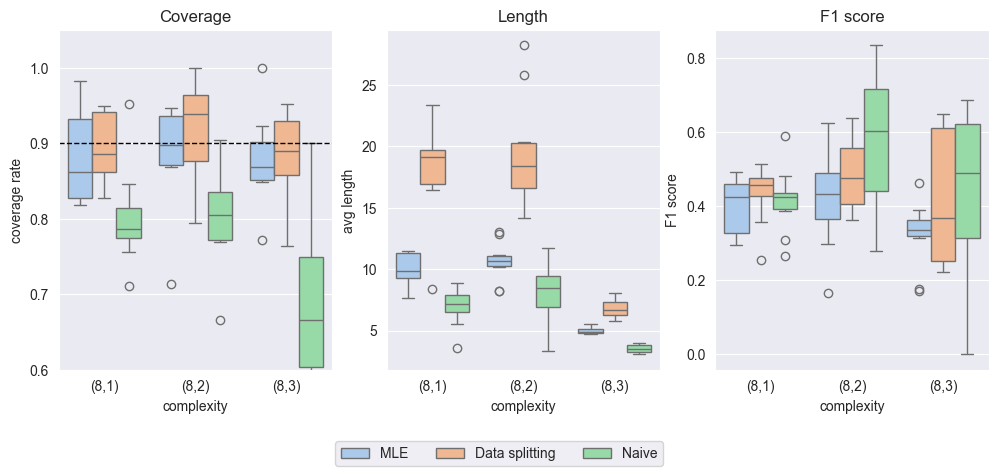

In [83]:
plotting('bspline_vary_complexity0_10.csv')

In [ ]:
def randomization_inference_spline(design, Y, n, p, Y_mean, groups,
                                   randomizer_scale=1.,
                                   weight_frac=1.25, level=0.9, ridge_term=1.):
    sigma_ = np.std(Y)
    if n > p:
        dispersion = np.linalg.norm(Y - design.dot(np.linalg.pinv(design).dot(Y))) ** 2 / (n - p)
    else:
        dispersion = sigma_ ** 2

    sigma_ = np.sqrt(dispersion)

    #weights = dict([(i, 0.5) for i in np.unique(groups)])
    weights = dict([(i, weight_frac * sigma_ * np.sqrt(2 * np.log(p))) for i in np.unique(groups)])

    conv = group_lasso.gaussian(X=design,
                                Y=Y,
                                groups=groups,
                                weights=weights,
                                useJacobian=True,
                                ridge_term=ridge_term)

    signs, _ = conv.fit()
    nonzero = (signs != 0)

    # print("MLE selection:", conv._ordered_groups)

    def solve_target_restricted():
        X_E = design[:,nonzero]
        _beta_unpenalized = np.linalg.inv(X_E.T @ X_E) @ X_E.T @ Y_mean
        """loglike = rr.glm.gaussian(design, Y_mean)
        # For LASSO, this is the OLS solution on X_{E,U}
        _beta_unpenalized = restricted_estimator(loglike,
                                                 nonzero)"""
        return _beta_unpenalized

    if nonzero.sum() > 0:
        print("MLE |E|:", nonzero.sum())

        conv.setup_inference(dispersion=dispersion)

        target_spec = selected_targets(conv.loglike,
                                       conv.observed_soln,
                                       dispersion=dispersion)

        result,_ = conv.inference(target_spec,
                                method='selective_MLE',
                                level=level)

        pval = result['pvalue']
        intervals = np.asarray(result[['lower_confidence',
                                       'upper_confidence']])

        beta_target = solve_target_restricted()

        coverage = (beta_target > intervals[:, 0]) * (beta_target < intervals[:, 1])
        
        
        np.set_printoptions(precision=3, suppress=True)
        print(beta_target)
        print(intervals)

        return coverage, (intervals[:, 1] - intervals[:, 0]), beta_target, \
               nonzero, intervals[:, 0], intervals[:, 1], target_spec.cov_target
    return None, None, None, None, None, None

In [ ]:
n, p = design.shape
noselection = False  # flag for a certain method having an empty selected set

if not noselection:
    # MLE inference
    coverage, length, beta_target, nonzero, conf_low, conf_up, cov_target = \
        randomization_inference_spline(design=design, Y=Y, n=n, p=p, Y_mean=Y_mean,
                                       groups=groups,
                                       weight_frac=1.25, level=0.9, ridge_term=0.)
    # print(MLE_runtime)
    noselection = (coverage is None)

In [ ]:
np.mean(coverage)

In [ ]:
design[:,nonzero] @ beta_target

In [ ]:
Y_mean

In [ ]:
Y